In [1]:
from utils_v1 import *


In [2]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential, TrainerEvidentialUEO
import src.trainer.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric


In [3]:
from enum import Enum
UncertaintyMethod = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
uncertaintyMethod = "evidential"


In [4]:

config = {
	"training": True,
	"learning_rate": 1e-3, # 1e-3
	#"learning_rate": 1e-5, # 1e-3	
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": uncertaintyMethod,
	"evidence_function": evidential.relu_evidence
}

'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
dates = [2018, 2019]
dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
	addPastDeforestationInput = config['addPastDeforestationInput'],
	borderBuffer = 2)	
# dates = [2019, 2020]
# dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
# 	addPastDeforestationInput = config['addPastDeforestationInput'],
# 	borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

# exp = 170
# exp = 155
exp = 155 # relu
# exp = 171 # softsign
# exp = 177
exp = 186

# if config["training"] == True:
trainer = TrainerEvidentialUEO(config, dataset, patchesHandler)

trainer.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2018, 2019]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [5]:
exp

186

In [6]:
trainer.setExperimentPath()
trainer.createLogFolders()

In [7]:
# ic(type(dataset), exp, dataset.dates)


In [8]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/Para/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Label where deforestation past years is actual date (2019) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/deforestation_before_2008/deforestation_before_2008_para.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([124211220,  38957970], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([132185553,   3150503,   4571354,    864429,    903608,   1299506,
                                                                      2477971,   1561686,   1459696,    969060,    644976,   2209014,
                                                                      2100204,   5257014,   3514616], dtype=int64))
ic| label_per_date.shape: (17730, 9203, 1)


Mask label shape:  
 (17730, 9203, 1) 
 Unique values:  
 [0 1 2]


In [9]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3546 2300
Mask size:  (17730, 9200)


In [10]:

trainer.label_mask.dtype

dtype('uint8')

In [11]:

trainer.getLabelCurrentDeforestation()

In [12]:

trainer.loadInputImage()

ic| image_stack.shape: (17730, 9203, 21)


Image shape:  (17730, 9203, 21)
mask:  (17730, 9200)
image stack:  (17730, 9200, 21)
ref : (17730, 9200, 1)


In [13]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.08333334, 0.16666667, 0.25      , 0.33333334,
        0.4166667 , 0.5       , 0.5833334 , 0.6666667 , 0.75      ,
        0.8333334 , 0.9166667 , 1.        ], dtype=float32),
 array([104050616,   2209014,    644713,    968315,   1458862,   1560879,
          2477424,   1299508,    903419,    864429,   4570932,   3150455,
         38957434], dtype=int64))

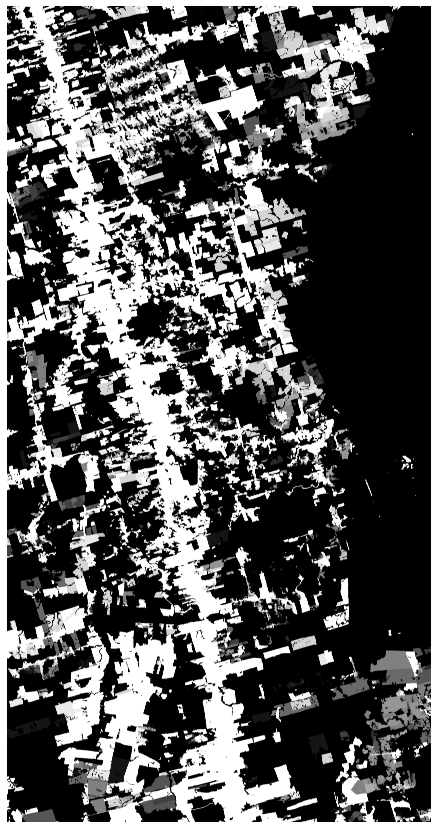

In [14]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [15]:

trainer.getImageChannels()

ic| self.image_stack.shape: (17730, 9200, 21)
ic| self.channels: 21


In [16]:

trainer.getTrainValTestMasks()

Training tiles:  [1, 3, 5, 8, 11, 13, 14, 20]
Validation tiles:  [6, 19]
Test tiles:  [2, 4, 7, 9, 10, 12, 15, 16, 17, 18]


In [17]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


ic| im_idx_row.shape: (17730, 9200, 1)
    im_idx_col.shape: (17730, 9200, 1)
ic| im_idx_row.dtype: dtype('uint16')
    im_idx_col.dtype: dtype('uint16')
ic| im_idx.shape: (17730, 9200, 2), im_idx.dtype: dtype('uint16')


In [18]:
if config["training"] == True:
    trainer.extractCoords()

ic| coords.shape: (464, 239, 1, 128, 128, 2)
    coords.dtype: dtype('uint16')
ic| coords.shape: (110896, 2), coords.dtype: dtype('uint16')


In [19]:
if config["training"] == True:
    trainer.trainTestSplit()

ic| self.coords_train.shape: (41812, 3)
    self.coords_val.shape: (10260, 3)


In [20]:
if config["training"] == True:
    trainer.label_mask.shape

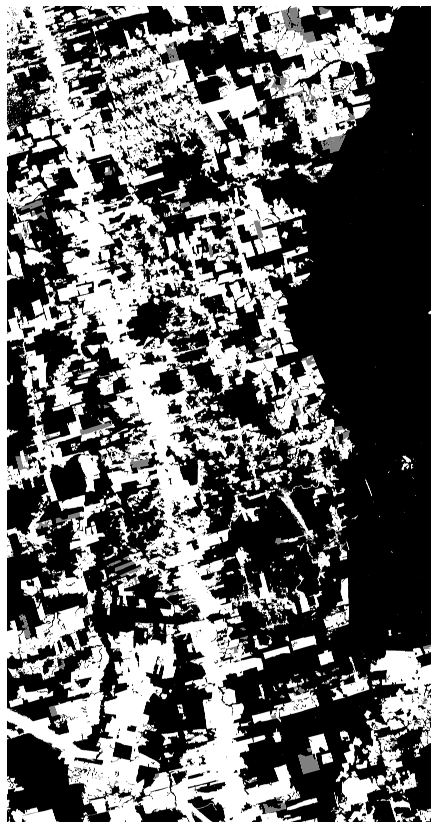

In [21]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [22]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [23]:
if config["training"] == True:
    print(trainer.coords_train)

[[    0     0     0]
 [    0    38     0]
 [    0    76     0]
 ...
 [17594  8968     0]
 [17594  9006     0]
 [17594  9044     0]]


In [24]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

training samples:  (3753, 3) validation samples:  (1032, 3)


In [25]:
if config["training"] == True:
    inputSnipShow = True

ic| np.mean(image_patch[...,[1,2,3]]): 0.107682176
    np.mean(image_patch[...,[11,12,13]]): 0.22637562


[12084  2508     0]


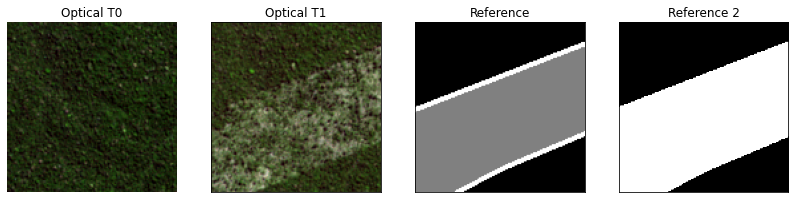

In [26]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


ic| np.mean(image_patch[...,[1,2,3]]): 0.2714837
    np.mean(image_patch[...,[11,12,13]]): 0.30292988
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 114 5928    0]


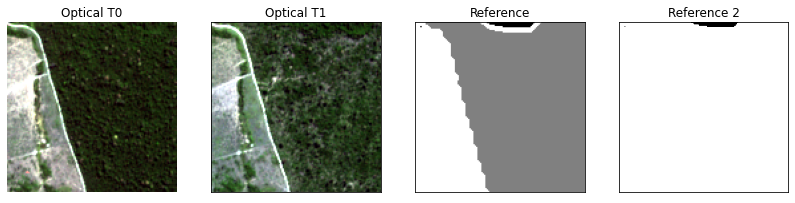

In [27]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


ic| np.mean(image_patch[...,[1,2,3]]): 0.15096879
    np.mean(image_patch[...,[11,12,13]]): 0.103304155


[3382 2128    0]


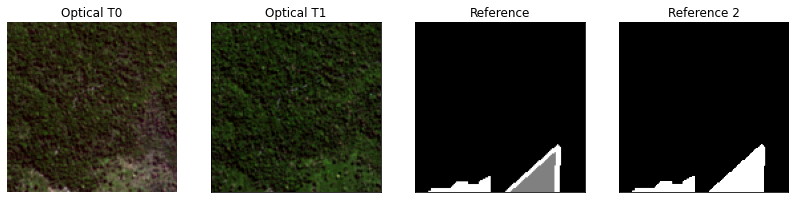

In [28]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

ic| np.mean(image_patch[...,[1,2,3]]): 0.09604081
    np.mean(image_patch[...,[11,12,13]]): 0.23388559


[ 608 6574    0]


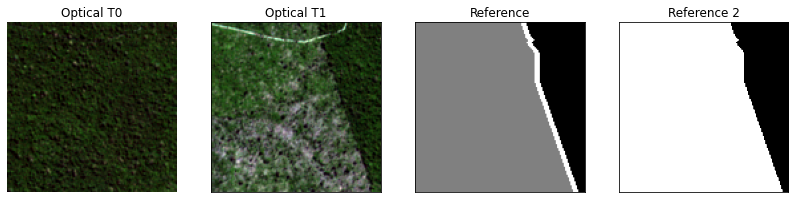

In [29]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [30]:
if config["training"] == True:
    trainer.getGenerators()


In [31]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [32]:
if config["training"] == True:
    print(trainer.path_exp)

D:/Jorge/datasets/deforestation/experiments/exp186


In [33]:
if config["training"] == True:
    print(trainer.channels)

21


In [34]:
if config["training"] == True:
    print(trainer.image_stack.shape)

(17730, 9200, 21)


In [35]:
# trainer.weights = [0.01, 0.99, 0]
trainer.weights

[0.1, 0.9, 0]

### Evidential metrics

In [36]:
if config["training"] == True:
    trainer.train()

time:  0
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_enc_net (InputLayer)      [(None, 128, 128, 21 0                                            
__________________________________________________________________________________________________
res1_net1 (Conv2D)              (None, 128, 128, 16) 3040        input_enc_net[0][0]              
__________________________________________________________________________________________________
drop_net1 (Dropout)             (None, 128, 128, 16) 0           res1_net1[0][0]                  
__________________________________________________________________________________________________
res2_net1 (Conv2D)              (None, 128, 128, 16) 2320        drop_net1[0][0]                  
_____________________________________________________________________________________

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\engine\training.py:1969: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
self.global_step 0.0
alpha Tensor("loss/add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("loss/truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(Y) Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32)
K.int_shape(prob) Tensor("loss/truediv_1:0", shape=(None, 128, 128, 3), dtype=float32)
alpha Tensor("add:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_6:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_7:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_5:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(KL_reg) Tensor("mul_12:0", shape=(None, 128, 128, 1), dtype=float32)
alpha Tensor("add_16:0", shape=(None, 128, 128, 3), dtype=float32)
u Tensor("truediv_13:0", shape=(None, 128, 128, 1), dtype=float32)
K.int_shape(Y) Tensor("IteratorGetNext:1", shape=(None, None, None, None), dtype=float32)
K.int_s

c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


351/351 [==============================] - 31s 88ms/step - loss: 0.3057 - accuracy: 0.5079 - KL_term: 0.0078 - loglikelihood_term: 0.7609 - evidential_success: 51.5135 - evidential_fail: 3.4510 - acc: 0.5074 - annealing_coef: 0.0933 - global_step_get: 350.0000 - annealing_step_get: 3750.0000 - UEO_term: 0.0501 - val_loss: 0.4816 - val_accuracy: 0.4669 - val_KL_term: 0.0277 - val_loglikelihood_term: 0.7332 - val_evidential_success: 67.1373 - val_evidential_fail: 5.6086 - val_acc: 0.4598 - val_annealing_coef: 0.1867 - val_global_step_get: 700.0000 - val_annealing_step_get: 3750.0000 - val_UEO_term: 0.2351

Epoch 00002: val_loss improved from 0.52131 to 0.48155, saving model to D:/Jorge/datasets/deforestation/experiments/exp186/models\resunet_0.h5
Epoch 3/100
self.global_step 700.0
351/351 [==============================] - 31s 87ms/step - loss: 0.3045 - accuracy: 0.5131 - KL_term: 0.0105 - loglikelihood_term: 0.7560 - evidential_success: 62.0418 - evidential_fail: 3.6528 - acc: 0.5134 - 

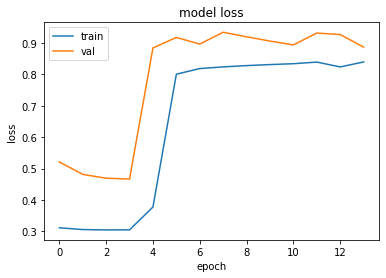

In [37]:
if config["training"] == True:
    trainer.plotHistory()


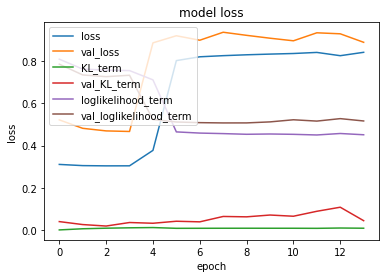

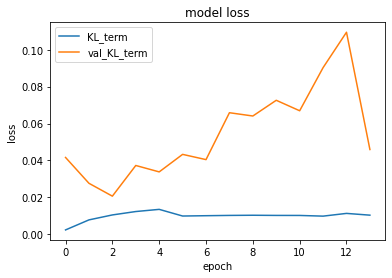

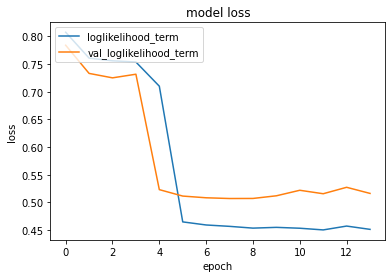

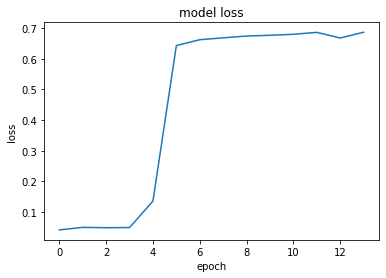

In [38]:
if config["training"] == True:
    trainer.plotLossTerms()

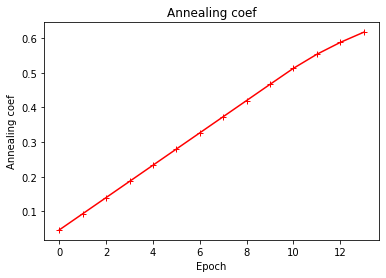

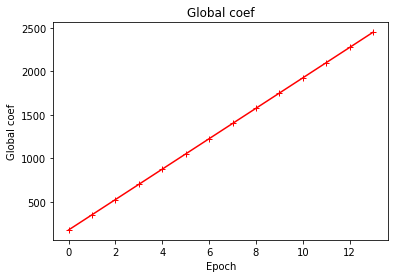

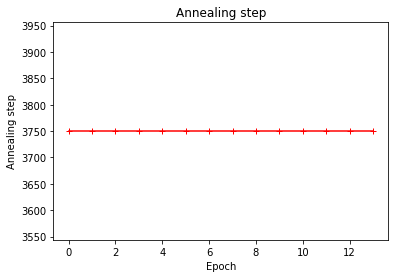

In [39]:
if config["training"] == True:
    trainer.plotAnnealingCoef()

In [40]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

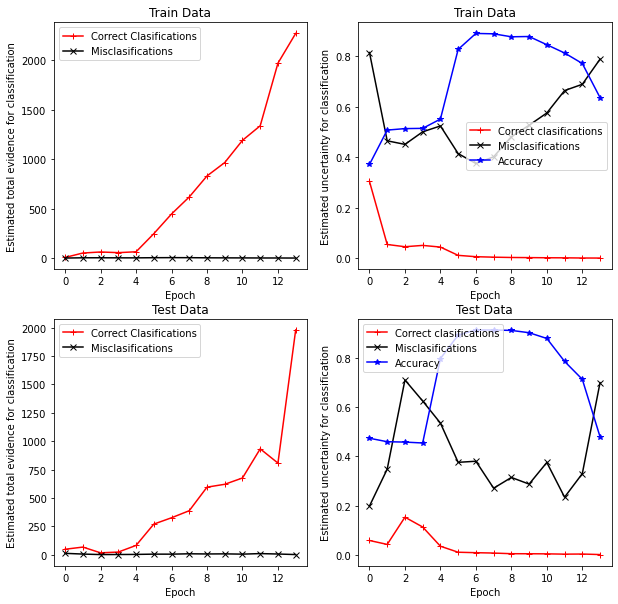

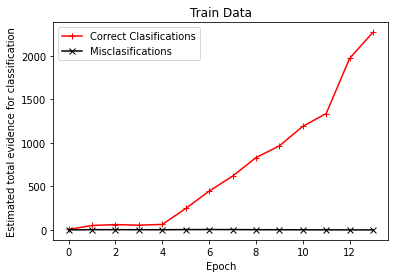

In [41]:
if config["training"] == True:
    draw_EDL_results(trainer.class_n, trainer.history.history)

    plt.figure(5)
    plt.plot(trainer.history.history['evidential_success'],c='r',marker='+')
    plt.plot(trainer.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [42]:
trainer.image_stack.shape

(17730, 9200, 21)

In [43]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [44]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]

In [45]:
trainer.image_stack.shape

(17730, 9200, 21)

In [46]:
trainer.setPadding()

-30.0 -16.0


In [47]:
trainer.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/exp186/models/resunet_0.h5'


time:  0


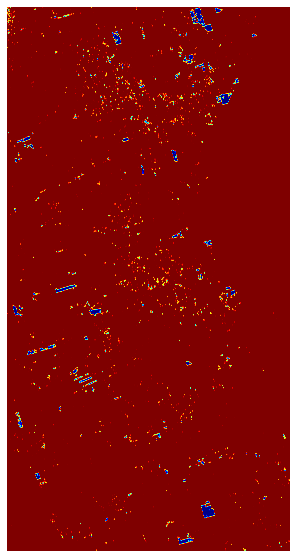

In [48]:
trainer.logger.plotFigure(trainer.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [49]:
trainer.loadPredictedProbabilities()


In [50]:
trainer.prob_rec.shape

(17760, 9216)

In [51]:
trainer.getMeanProb()

In [52]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.32354516
    np.mean(value): 0.34143865
    np.max(value): 0.9922354


In [53]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (17760, 9216)


(17760, 9216)

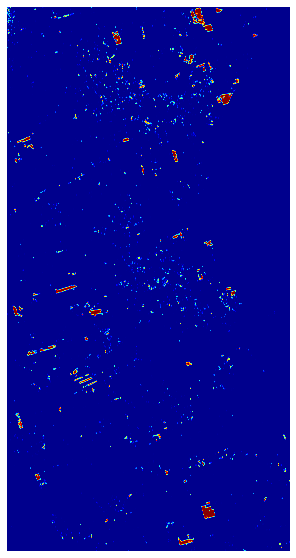

In [54]:
trainer.unpadMeanProb()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

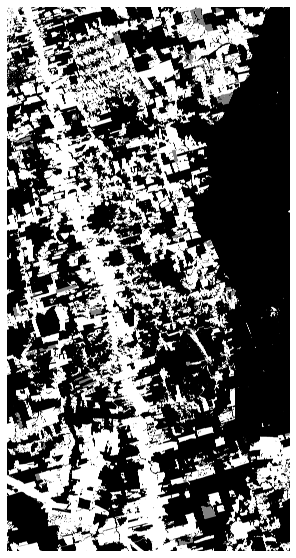

In [55]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [56]:
trainer.squeezeLabel()

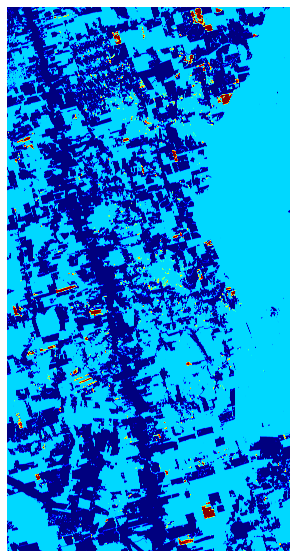

In [57]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [58]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.21767591
    np.max(value): 0.9922354


In [59]:
print(trainer.label_mask.shape)

(17730, 9200)


In [60]:
trainer.getLabelTest()

(54236371,)
(array([0, 1], dtype=uint8), array([53470765,   765606], dtype=int64))


In [61]:
trainer.getMAP()

82.36


In [62]:
trainer.prob_rec.shape

(17760, 9216)

In [63]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(17760, 9216, 1)


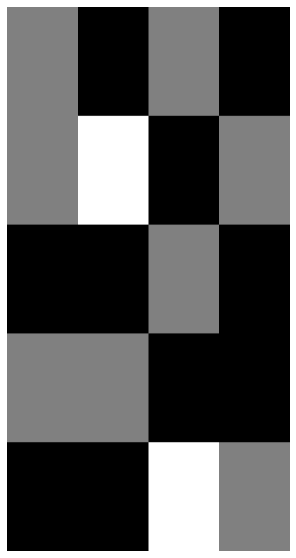

In [64]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [65]:
trainer.getLabelCurrentDeforestation()

In [66]:
trainer.applyProbabilityThreshold()

(17730, 9200)
(array([0., 1.], dtype=float32), array([160795008,   2320992], dtype=int64))


ic| self.predicted_unpad.shape: (17730, 9200)
    self.predicted.shape: (17730, 9200)


In [67]:
trainer.getTestValues()

ic| predicted_test.shape: (81558000,)
ic| predicted_test.shape: (54236371,)


In [68]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([160795008,   2320992], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([161164493,   1951507], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([162746515,    369485], dtype=int64))


In [69]:
trainer.calculateMetrics()

ic| self.f1: 80.57, self.precision: 77.99, self.recall: 83.33


In [70]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (16311600,)
ic| self.label_mask_val_valid.shape: (9411878,)
ic| f1_val: 82.65
    precision_val: 76.59
    recall_val: 89.74
    mAP_val: 86.02


In [71]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [72]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([162298481,    817519], dtype=int64))


In [73]:
'''

import types

trainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [74]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


In [75]:
predicted_unpad_to_show = trainer.predicted_unpad.copy()

predicted_unpad_to_show[trainer.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [76]:
predicted_unpad_to_show.shape

(17730, 9200)

In [77]:

'''
trainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

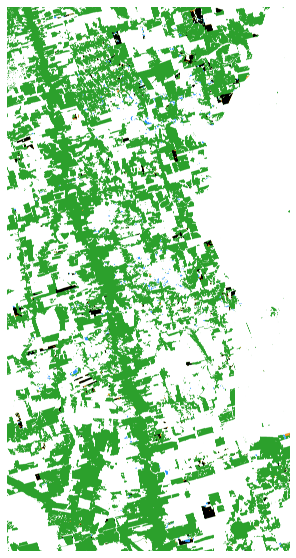

In [78]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [79]:
trainer.setUncertainty()

In [80]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (17730, 9200)
ic| self.mask_amazon_ts.shape: (17730, 9200)
ic| self.label_mask_test.shape: (81558000,)
ic| self.error_mask_test.shape: (54058198,)


In [81]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0, np.mean(value): 0.61729896, np.max(value): 1.0


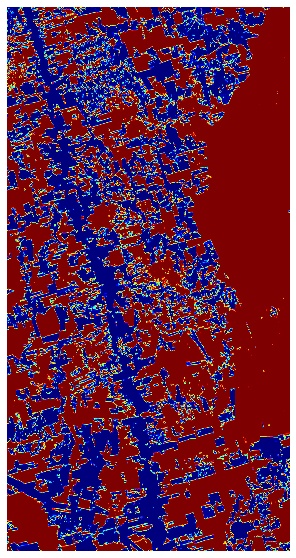

In [82]:
trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([2200, 3200, 6900, 7900])
    trainer.dataset.previewLims2: array([ 500, 1500, 3500, 4500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([1000000], dtype=int64))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


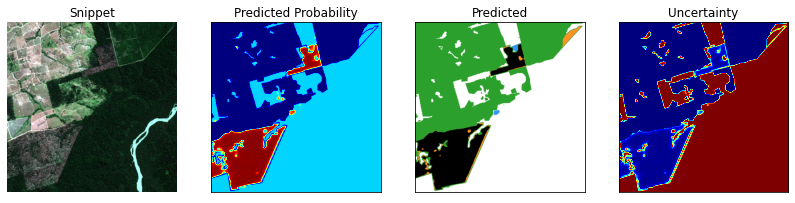

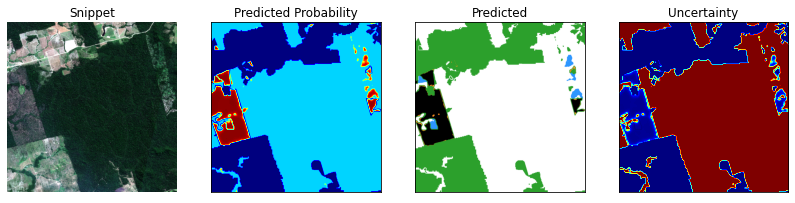

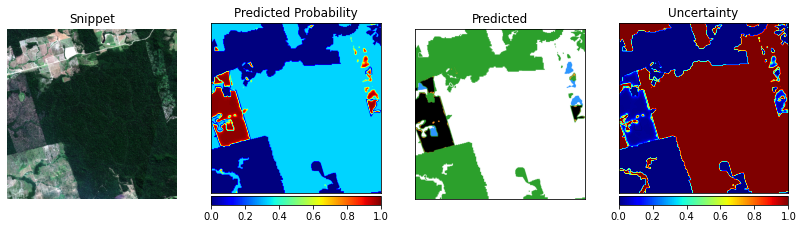

In [83]:
trainer.logger.plotCropSample(trainer)

In [84]:
trainer.logger.getStats(trainer.uncertainty)

ic| np.min(value): 0.012826333
    np.mean(value): 0.9875177
    np.max(value): 1.0


In [85]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
def getMassFcn(self, alpha = [5, 5, 5]):
        draw_pdf_contours(Dirichlet(alpha))


In [86]:

import types

trainer.getMassFcn = types.MethodType(getMassFcn, trainer)


In [87]:
from sklearn import metrics
def getUncertaintyMetrics(self):
    predicted_thresholded = np.zeros_like(self.uncertainty).astype(np.int8)
    predicted_thresholded[self.uncertainty * 2.8 >= np.max(self.predicted_test,axis=-1)] = 1
    print(np.unique(predicted_thresholded, return_counts=True))

    predicted_test_classified_correct = self.predicted_test[
            predicted_thresholded == 0]
    label_current_deforestation_test_classified_correct = self.label_mask_current_deforestation_test[
            predicted_thresholded == 0]


    predicted_test_classified_incorrect = self.predicted_test[
            predicted_thresholded == 1]
    label_current_deforestation_test_classified_incorrect = self.label_mask_current_deforestation_test[
            predicted_thresholded == 1]

    uncertainty_classified_correct = self.uncertainty[
            predicted_thresholded == 0]
    uncertainty_classified_incorrect = self.uncertainty[
            predicted_thresholded == 1]
    print(np.min(uncertainty_classified_correct), np.mean(uncertainty_classified_correct), np.max(uncertainty_classified_correct))
    print(np.min(uncertainty_classified_incorrect), np.mean(uncertainty_classified_incorrect), np.max(uncertainty_classified_incorrect))

    print(label_current_deforestation_test_classified_correct.shape,
            predicted_test_classified_correct.shape)
    cm_correct = metrics.confusion_matrix(
            label_current_deforestation_test_classified_correct,
            predicted_test_classified_correct)
    print("cm_correct", cm_correct)

    TN_L = cm_correct[0,0]
    FN_L = cm_correct[1,0]
    TP_L = cm_correct[1,1]
    FP_L = cm_correct[0,1]

    ic(label_current_deforestation_test_classified_incorrect.shape,
            predicted_test_classified_incorrect.shape)

    cm_incorrect = metrics.confusion_matrix(
            label_current_deforestation_test_classified_incorrect,
            predicted_test_classified_incorrect)

    print("cm_incorrect", cm_incorrect)

    if cm_incorrect.shape[0] != 2: 
            ic(np.all(label_current_deforestation_test_classified_incorrect) == 0) 
            ic(np.all(predicted_test_classified_incorrect) == 0) 
            
            precision_L = np.nan 
            recall_L = np.nan 
            recall_Ltotal = np.nan 
            AA = len(label_current_deforestation_test_classified_incorrect) / len(self.label_mask_current_deforestation_test) 
            precision_H = np.nan 
            recall_H = np.nan 
    else:
                    
            TN_H = cm_incorrect[0,0]
            FN_H = cm_incorrect[1,0]
            TP_H = cm_incorrect[1,1]
            FP_H = cm_incorrect[0,1]
            
            precision_L = TP_L / (TP_L + FP_L)
            recall_L = TP_L / (TP_L + FN_L)
            
            precision_H = TP_H / (TP_H + FP_H)
            recall_H = TP_H / (TP_H + FN_H)
            
            recall_Ltotal = TP_L / (TP_L + FN_L + TP_H + FN_H)
            ic((TP_H + FN_H + FP_H + TN_H), len(self.label_mask_current_deforestation_test))
            AA = (TP_H + FN_H + FP_H + TN_H) / len(self.label_mask_current_deforestation_test)
            ic((TP_H + FN_H + FP_H + TN_H), len(self.label_mask_current_deforestation_test))


    self.m = {'precision_L': precision_L,
            'recall_L': recall_L,
            'recall_Ltotal': recall_Ltotal,
            'AA': AA,
            'precision_H': precision_H,
            'recall_H': recall_H}

    self.m['f1_L'] = 2*self.m['precision_L']*self.m['recall_L']/(self.m['precision_L']+self.m['recall_L'])
    self.m['f1_H'] = 2*self.m['precision_H']*self.m['recall_H']/(self.m['precision_H']+self.m['recall_H'])


In [88]:

import types

trainer.getUncertaintyMetrics = types.MethodType(getUncertaintyMetrics, trainer)


In [89]:
trainer.getUncertaintyMetrics()

(array([0, 1], dtype=int8), array([  652359, 53405839], dtype=int64))


ic| label_current_deforestation_test_classified_incorrect.shape: (53405839,)
    predicted_test_classified_incorrect.shape: (53405839,)


0.012826333 0.0904943 0.35713354
0.35714433 0.9984755 1.0
(652359,) (652359,)
cm_correct [[     0  90620]
 [     0 561739]]


ic| TP_H + FN_H + FP_H + TN_H: 53405839
    len(self.label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53405839
    len(self.label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    80745]
 [  121462    45345]]


In [90]:
trainer.m

{'precision_L': 0.8610887563442828,
 'recall_L': 1.0,
 'recall_Ltotal': 0.7710412245760735,
 'AA': 0.9879322836473388,
 'precision_H': 0.3596240780394956,
 'recall_H': 0.27184110978556053,
 'f1_L': 0.9253602262749795,
 'f1_H': 0.3096310307036262}

In [91]:
print(trainer.uncertainty.shape, trainer.predicted_test.shape)
print(trainer.uncertainty.dtype, trainer.predicted_test.dtype)
print(np.unique(trainer.predicted_test))
print(trainer.label_mask_current_deforestation_test.shape)


(54058198,) (54058198,)
float32 float32
[0. 1.]
(54058198,)


In [92]:
trainer.mean_prob[trainer.mask_amazon_ts == 1].shape

(81558000,)

In [93]:
uncertainty_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]

predicted_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]


In [94]:
print(np.min(uncertainty_test_correct), np.mean(uncertainty_test_correct), np.max(uncertainty_test_correct))
print(np.min(uncertainty_test_incorrect), np.mean(uncertainty_test_incorrect), np.max(uncertainty_test_incorrect))


0.012826333 0.9895532 1.0
0.02268358 0.61396337 1.0


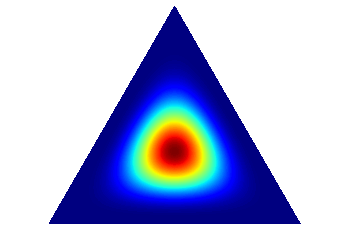

In [95]:
trainer.getMassFcn()

In [96]:
trainer.m

{'precision_L': 0.8610887563442828,
 'recall_L': 1.0,
 'recall_Ltotal': 0.7710412245760735,
 'AA': 0.9879322836473388,
 'precision_H': 0.3596240780394956,
 'recall_H': 0.27184110978556053,
 'f1_L': 0.9253602262749795,
 'f1_H': 0.3096310307036262}

In [97]:
trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (54058198,)
    self.label_mask_current_deforestation_test.shape: (54058198,)


[0.13, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.13


ic| label_current_deforestation_test_classified_incorrect.shape: (53566401,)
    predicted_test_classified_incorrect.shape: (53566401,)


(491797,) (491797,)
cm_correct [[     0  19646]
 [     0 472151]]


ic| TP_H + FN_H + FP_H + TN_H: 53566401
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53566401
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287   151719]
 [  121462   134933]]
[0.96005262 1.         0.64807301 0.99090245 0.4707206  0.52627001
 0.00509799]
threshold 0.15


ic| label_current_deforestation_test_classified_incorrect.shape: (53540424,)
    predicted_test_classified_incorrect.shape: (53540424,)


(517774,) (517774,)
cm_correct [[     0  26726]
 [     0 491048]]


ic| TP_H + FN_H + FP_H + TN_H: 53540424
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53540424
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287   144639]
 [  121462   116036]]
[0.94838289 1.         0.67401098 0.99042192 0.44513666 0.48857675
 0.00496762]
threshold 0.2


ic| label_current_deforestation_test_classified_incorrect.shape: (53492426,)
    predicted_test_classified_incorrect.shape: (53492426,)


(565772,) (565772,)
cm_correct [[     0  44934]
 [     0 520838]]


ic| TP_H + FN_H + FP_H + TN_H: 53492426
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53492426
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287   126431]
 [  121462    86246]]
[0.92057931 1.         0.71490064 0.98953402 0.40552575 0.41522715
 0.00463028]
threshold 0.225


ic| label_current_deforestation_test_classified_incorrect.shape: (53473749,)
    predicted_test_classified_incorrect.shape: (53473749,)


(584449,) (584449,)
cm_correct [[     0  53825]
 [     0 530624]]


ic| TP_H + FN_H + FP_H + TN_H: 53473749
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53473749
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287   117540]
 [  121462    76460]]
[0.90790471 1.         0.72833287 0.98918852 0.39412371 0.3863138
 0.00446503]
threshold 0.25


ic| label_current_deforestation_test_classified_incorrect.shape: (53457756,)
    predicted_test_classified_incorrect.shape: (53457756,)


(600442,) (600442,)
cm_correct [[     0  62052]
 [     0 538390]]


ic| TP_H + FN_H + FP_H + TN_H: 53457756
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53457756
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287   109313]
 [  121462    68694]]
[0.89665613 1.         0.73899246 0.98889267 0.38590617 0.36125076
 0.00431195]
threshold 0.27


ic| label_current_deforestation_test_classified_incorrect.shape: (53446384,)
    predicted_test_classified_incorrect.shape: (53446384,)


(611814,) (611814,)
cm_correct [[     0  68006]
 [     0 543808]]


ic| TP_H + FN_H + FP_H + TN_H: 53446384
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53446384
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287   103359]
 [  121462    63276]]
[0.8888453  1.         0.74642919 0.98868231 0.37972815 0.34251751
 0.00420113]
threshold 0.3


ic| label_current_deforestation_test_classified_incorrect.shape: (53431407,)
    predicted_test_classified_incorrect.shape: (53431407,)


(626791,) (626791,)
cm_correct [[     0  76017]
 [     0 550774]]


ic| TP_H + FN_H + FP_H + TN_H: 53431407
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53431407
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    95348]
 [  121462    56310]]
[0.87872034 1.         0.7559907  0.98840526 0.37129594 0.31675404
 0.00405196]
threshold 0.34


ic| label_current_deforestation_test_classified_incorrect.shape: (53413321,)
    predicted_test_classified_incorrect.shape: (53413321,)


(644877,) (644877,)
cm_correct [[     0  86233]
 [     0 558644]]


ic| TP_H + FN_H + FP_H + TN_H: 53413321
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53413321
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    85132]
 [  121462    48440]]
[0.86627993 1.         0.76679304 0.98807069 0.36265085 0.28510553
 0.0038616 ]
threshold 0.36


ic| label_current_deforestation_test_classified_incorrect.shape: (53404559,)
    predicted_test_classified_incorrect.shape: (53404559,)


(653639,) (653639,)
cm_correct [[     0  91392]
 [     0 562247]]


ic| TP_H + FN_H + FP_H + TN_H: 53404559
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53404559
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    79973]
 [  121462    44837]]
[0.8601797  1.         0.7717385  0.98790861 0.35924205 0.26961677
 0.00376543]
threshold 0.45


ic| label_current_deforestation_test_classified_incorrect.shape: (53368195,)
    predicted_test_classified_incorrect.shape: (53368195,)


(690003,) (690003,)
cm_correct [[     0 114543]
 [     0 575460]]


ic| TP_H + FN_H + FP_H + TN_H: 53368195
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53368195
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    56822]
 [  121462    31624]]
[0.83399637 1.         0.78987463 0.98723592 0.3575515  0.2065767
 0.00333349]
threshold 0.55


ic| label_current_deforestation_test_classified_incorrect.shape: (53334427,)
    predicted_test_classified_incorrect.shape: (53334427,)


(723771,) (723771,)
cm_correct [[     0 136239]
 [     0 587532]]


ic| TP_H + FN_H + FP_H + TN_H: 53334427
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53334427
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    35126]
 [  121462    19552]]
[0.81176505 1.         0.80644462 0.98661126 0.3575844  0.1386529
 0.00292848]
threshold 0.65


ic| label_current_deforestation_test_classified_incorrect.shape: (53305754,)
    predicted_test_classified_incorrect.shape: (53305754,)


(752444,) (752444,)
cm_correct [[     0 154386]
 [     0 598058]]


ic| TP_H + FN_H + FP_H + TN_H: 53305754
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53305754
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    16979]
 [  121462     9026]]
[0.79482061 1.         0.82089257 0.98608085 0.3470871  0.06917111
 0.00258961]
threshold 0.8


ic| label_current_deforestation_test_classified_incorrect.shape: (53244513,)
    predicted_test_classified_incorrect.shape: (53244513,)


(813685,) (813685,)
cm_correct [[ 29399 171365]
 [  5837 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53244513
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53244513
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53128888        0]
 [  115625        0]]
[0.77986355 0.99047675 0.83328163 0.98494798        nan 0.
 0.00216438]


In [98]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (54058198,)
    self.label_mask_current_deforestation_test.shape: (54058198,)


threshold 0.13
(54058198,) (54058198,)
cm_audited [[53310006    19646]
 [       0   728546]]
[0.97374203 1.        ]
threshold 0.15
(54058198,) (54058198,)
cm_audited [[53302926    26726]
 [       0   728546]]
[0.96461407 1.        ]
threshold 0.2
(54058198,) (54058198,)
cm_audited [[53284718    44934]
 [       0   728546]]
[0.94190671 1.        ]
threshold 0.225
(54058198,) (54058198,)
cm_audited [[53275827    53825]
 [       0   728546]]
[0.93120272 1.        ]
threshold 0.25
(54058198,) (54058198,)
cm_audited [[53267600    62052]
 [       0   728546]]
[0.92151258 1.        ]
threshold 0.27
(54058198,) (54058198,)
cm_audited [[53261646    68006]
 [       0   728546]]
[0.91462453 1.        ]
threshold 0.3
(54058198,) (54058198,)
cm_audited [[53253635    76017]
 [       0   728546]]
[0.90551765 1.        ]
threshold 0.34
(54058198,) (54058198,)
cm_audited [[53243419    86233]
 [       0   728546]]
[0.89416394 1.        ]
threshold 0.36
(54058198,) (54058198,)
cm_audited [[53238260    9

ic| metric_values_audited: array([[0.97374203, 1.        ],
                                  [0.96461407, 1.        ],
                                  [0.94190671, 1.        ],
                                  [0.93120272, 1.        ],
                                  [0.92151258, 1.        ],
                                  [0.91462453, 1.        ],
                                  [0.90551765, 1.        ],
                                  [0.89416394, 1.        ],
                                  [0.88853791, 1.        ],
                                  [0.8641389 , 1.        ],
                                  [0.84245911, 1.        ],
                                  [0.82514395, 1.        ],
                                  [0.80833242, 0.99198815]])


cm_audited [[53158287   171365]
 [    5837   722709]]
[0.80833242 0.99198815]


In [99]:
trainer.setPlotLimsForUncertaintyAA()

In [100]:

def plotUncertaintyAA(self):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.plot(self.m['AA']*100, self.m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m_audited['precision']*100, 'C2-', label="Precision Audited")
    ax1.plot(self.m['AA']*100, self.m_audited['recall']*100, 'C2--', label="Recall Audited")

    ax1.legend(loc="lower right")
    ax1.set_ylabel('Precision/recall (%)')
    ax1.set_xlabel('Audit Area (%)')
    ax1.set_ylim(self.ylim)
    ax1.set_xlim(self.xlim)
    ax1.grid()

    xs = [0, 120]
    ax1.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = 'vline_multiple - full height')

    ax2.plot(range(int(self.xlim[0]), int(self.xlim[1] + 2)), 
        np.ones(int(self.xlim[1] + 2)) * self.f1, 
        'C1:', label="F1 No Uncertainty")

    ax2.plot(self.m['AA']*100, self.m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
    ax2.plot(self.m['AA']*100, self.m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
    ax2.plot(self.m['AA']*100, self.m_audited['f1']*100, 'C2-', label="F1 Audited")

    ax2.legend(loc="lower right")
    ax2.set_ylabel('F1 score (%)')
    ax2.set_xlabel('Audit Area (%)')
    ax2.set_ylim(self.ylim)
    ax2.set_xlim(self.xlim)

    ax2.grid()

    xs = [0, 120]
    ax2.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.plot(np.asarray(self.threshold_list), self.m['AA']*100, label="AA")
    ax3.set_ylabel('Audit Area (%)')
    ax3.set_xlabel('Uncertainty Threshold')
    ax3.grid()
    ax3.set_ylim(self.xlim)

    self.xlim_adjusted = ax3.get_xlim()
    ax3.hlines(y = 3, xmin = self.xlim_adjusted[0], xmax = self.xlim_adjusted[1],
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.set_xlim(self.xlim_adjusted)

    # if save_figures == True:
    if True:
        plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

def plotUEO(self): 

    plt.plot(self.m['AA']*100, self.m['UEO'], label="UEO") 
    plt.grid() 
    plt.xlabel('Audit Area (%)') 
    plt.ylabel('UEO (%)') 
    plt.xlim(self.xlim)
    plt.ylim([0, 0.4])

import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
trainer.plotUEO = types.MethodType(plotUEO, trainer)


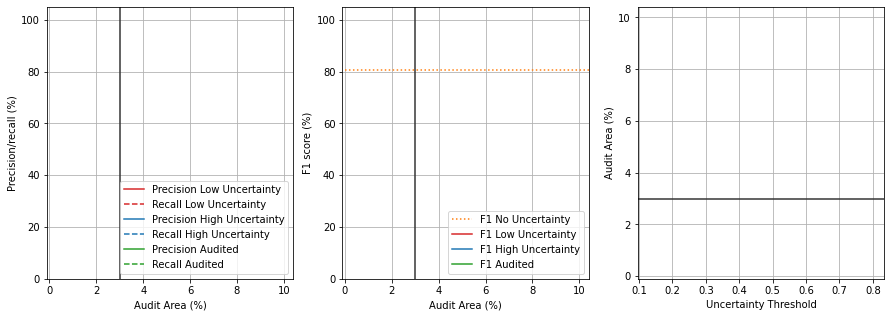

In [101]:
trainer.plotUncertaintyAA()

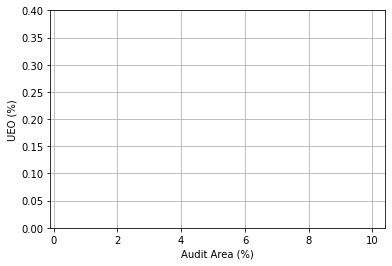

In [102]:
trainer.plotUEO()

In [103]:
trainer.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484


ic| label_current_deforestation_test_classified_incorrect.shape: (53395095,)
    predicted_test_classified_incorrect.shape: (53395095,)


(663103,) (663103,)
cm_correct [[     0  97169]
 [     0 565934]]


ic| TP_H + FN_H + FP_H + TN_H: 53395095
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53395095
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    74196]
 [  121462    41150]]
[0.85346319 1.         0.77679927 0.98773353 0.35675273 0.25305636
 0.00365769]
0.6176798867836452
threshold 0.6176798867836452


ic| label_current_deforestation_test_classified_incorrect.shape: (53314616,)
    predicted_test_classified_incorrect.shape: (53314616,)


(743582,) (743582,)
cm_correct [[     0 148837]
 [     0 594745]]


ic| TP_H + FN_H + FP_H + TN_H: 53314616
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53314616
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53158287    22528]
 [  121462    12339]]
[0.79983781 1.         0.81634516 0.98624479 0.35388763 0.09221904
 0.00269324]
0.7631402264327096
threshold 0.7631402264327096


ic| label_current_deforestation_test_classified_incorrect.shape: (53270725,)
    predicted_test_classified_incorrect.shape: (53270725,)


(787473,) (787473,)
cm_correct [[  7473 171365]
 [  1551 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53270725
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53270725
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53150814        0]
 [  119911        0]]
[0.77986355 0.99745167 0.83328163 0.98543287        nan 0.
 0.00224369]
0.8530396603509355
threshold 0.8530396603509355


ic| label_current_deforestation_test_classified_incorrect.shape: (53205736,)
    predicted_test_classified_incorrect.shape: (53205736,)


(852462,) (852462,)
cm_correct [[ 62595 171365]
 [ 11418 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53205736
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53205736
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53095692        0]
 [  110044        0]]
[0.77986355 0.98153927 0.83328163 0.98423066        nan 0.
 0.00206119]
0.9086005660817742
threshold 0.9086005660817742


ic| label_current_deforestation_test_classified_incorrect.shape: (53163938,)
    predicted_test_classified_incorrect.shape: (53163938,)


(894260,) (894260,)
cm_correct [[ 99003 171365]
 [ 16808 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53163938
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53163938
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53059284        0]
 [  104654        0]]
[0.77986355 0.97305944 0.83328163 0.98345746        nan 0.
 0.00196157]
0.9429390942691613
threshold 0.9429390942691613


ic| label_current_deforestation_test_classified_incorrect.shape: (53136684,)
    predicted_test_classified_incorrect.shape: (53136684,)


(921514,) (921514,)
cm_correct [[123103 171365]
 [ 19962 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53136684
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53136684
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53035184        0]
 [  101500        0]]
[0.77986355 0.96816502 0.83328163 0.9829533         nan 0.
 0.00190331]
0.9641614718126129
threshold 0.9641614718126129


ic| label_current_deforestation_test_classified_incorrect.shape: (53118906,)
    predicted_test_classified_incorrect.shape: (53118906,)


(939292,) (939292,)
cm_correct [[139027 171365]
 [ 21816 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53118906
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53118906
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53019260        0]
 [   99646        0]]
[0.77986355 0.96531086 0.83328163 0.98262443        nan 0.
 0.00186911]
0.9772776224565485
threshold 0.9772776224565485


ic| label_current_deforestation_test_classified_incorrect.shape: (53107698,)
    predicted_test_classified_incorrect.shape: (53107698,)


(950500,) (950500,)
cm_correct [[149087 171365]
 [ 22964 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53107698
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53107698
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53009200        0]
 [   98498        0]]
[0.77986355 0.96355198 0.83328163 0.9824171         nan 0.
 0.00184792]
0.9853838493560645
threshold 0.9853838493560645


ic| label_current_deforestation_test_classified_incorrect.shape: (53100656,)
    predicted_test_classified_incorrect.shape: (53100656,)


(957542,) (957542,)
cm_correct [[155398 171365]
 [ 23695 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53100656
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53100656
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[53002889        0]
 [   97767        0]]
[0.77986355 0.96243534 0.83328163 0.98228683        nan 0.
 0.00183443]
0.990393773100484
threshold 0.990393773100484


ic| label_current_deforestation_test_classified_incorrect.shape: (53096277,)
    predicted_test_classified_incorrect.shape: (53096277,)


(961921,) (961921,)
cm_correct [[159349 171365]
 [ 24123 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53096277
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53096277
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52998938        0]
 [   97339        0]]
[0.77986355 0.96178274 0.83328163 0.98220583        nan 0.
 0.00182653]
0.9934900762555805
threshold 0.9934900762555805


ic| label_current_deforestation_test_classified_incorrect.shape: (53093506,)
    predicted_test_classified_incorrect.shape: (53093506,)


(964692,) (964692,)
cm_correct [[161873 171365]
 [ 24370 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53093506
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53093506
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52996414        0]
 [   97092        0]]
[0.77986355 0.96140653 0.83328163 0.98215457        nan 0.
 0.00182198]
0.9954036968449036
threshold 0.9954036968449036


ic| label_current_deforestation_test_classified_incorrect.shape: (53091858,)
    predicted_test_classified_incorrect.shape: (53091858,)


(966340,) (966340,)
cm_correct [[163341 171365]
 [ 24550 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53091858
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53091858
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52994946        0]
 [   96912        0]]
[0.77986355 0.96113255 0.83328163 0.98212408        nan 0.
 0.00181865]
0.996586379410677
threshold 0.996586379410677


ic| label_current_deforestation_test_classified_incorrect.shape: (53090804,)
    predicted_test_classified_incorrect.shape: (53090804,)


(967394,) (967394,)
cm_correct [[164312 171365]
 [ 24633 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53090804
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53090804
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52993975        0]
 [   96829        0]]
[0.77986355 0.96100627 0.83328163 0.98210458        nan 0.
 0.00181713]
0.9973173174342268
threshold 0.9973173174342268


ic| label_current_deforestation_test_classified_incorrect.shape: (53090162,)
    predicted_test_classified_incorrect.shape: (53090162,)


(968036,) (968036,)
cm_correct [[164898 171365]
 [ 24689 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53090162
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53090162
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52993389        0]
 [   96773        0]]
[0.77986355 0.96092109 0.83328163 0.98209271        nan 0.
 0.0018161 ]
0.9977690619764502
threshold 0.9977690619764502


ic| label_current_deforestation_test_classified_incorrect.shape: (53089763,)
    predicted_test_classified_incorrect.shape: (53089763,)


(968435,) (968435,)
cm_correct [[165250 171365]
 [ 24736 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089763
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089763
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52993037        0]
 [   96726        0]]
[0.77986355 0.96084961 0.83328163 0.98208533        nan 0.
 0.00181523]
0.9980482554577765
threshold 0.9980482554577765


ic| label_current_deforestation_test_classified_incorrect.shape: (53089520,)
    predicted_test_classified_incorrect.shape: (53089520,)


(968678,) (968678,)
cm_correct [[165473 171365]
 [ 24756 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089520
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089520
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52992814        0]
 [   96706        0]]
[0.77986355 0.96081919 0.83328163 0.98208083        nan 0.
 0.00181486]
0.9982208065186736
threshold 0.9982208065186736


ic| label_current_deforestation_test_classified_incorrect.shape: (53089352,)
    predicted_test_classified_incorrect.shape: (53089352,)


(968846,) (968846,)
cm_correct [[165625 171365]
 [ 24772 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089352
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089352
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52992662        0]
 [   96690        0]]
[0.77986355 0.96079486 0.83328163 0.98207772        nan 0.
 0.00181457]
0.9983274489391029
threshold 0.9983274489391029


ic| label_current_deforestation_test_classified_incorrect.shape: (53089260,)
    predicted_test_classified_incorrect.shape: (53089260,)


(968938,) (968938,)
cm_correct [[165707 171365]
 [ 24782 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089260
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089260
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52992580        0]
 [   96680        0]]
[0.77986355 0.96077966 0.83328163 0.98207602        nan 0.
 0.00181438]
0.9983933575795707
threshold 0.9983933575795707


ic| label_current_deforestation_test_classified_incorrect.shape: (53089204,)
    predicted_test_classified_incorrect.shape: (53089204,)


(968994,) (968994,)
cm_correct [[165757 171365]
 [ 24788 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089204
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089204
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52992530        0]
 [   96674        0]]
[0.77986355 0.96077054 0.83328163 0.98207499        nan 0.
 0.00181427]
0.9984340913595322
threshold 0.9984340913595322


ic| label_current_deforestation_test_classified_incorrect.shape: (53089172,)
    predicted_test_classified_incorrect.shape: (53089172,)


(969026,) (969026,)
cm_correct [[165785 171365]
 [ 24792 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089172
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089172
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52992502        0]
 [   96670        0]]


ic| self.threshold_optimal: 0.9984340913595322


[0.77986355 0.96076445 0.83328163 0.98207439        nan 0.
 0.0018142 ]


In [104]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.9984340913595322


ic| label_current_deforestation_test_classified_incorrect.shape: (53089172,)
    predicted_test_classified_incorrect.shape: (53089172,)


(969026,) (969026,)
cm_correct [[165785 171365]
 [ 24792 607084]]


d:\Jorge\deforestation_uncertainty\src\metrics.py:295: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 53089172
    len(label_mask_current_deforestation_test): 54058198
ic| TP_H + FN_H + FP_H + TN_H: 53089172
    len(label_mask_current_deforestation_test): 54058198


cm_incorrect [[52992502        0]
 [   96670        0]]
[0.77986355 0.96076445 0.83328163 0.98207439        nan 0.
 0.0018142 ]
threshold 0.9984340913595322
(54058198,) (54058198,)


ic| self.m_optimal: {'AA': array([0.98207439]),
                     'UEO': array([0.0018142]),
                     'f1': 80.57,
                     'f1_H': array([nan]),
                     'f1_L': array([0.86091362]),
                     'precision_H': array([nan]),
                     'precision_L': array([0.77986355]),
                     'recall_H': array([0.]),
                     'recall_L': array([0.96076445]),
                     'recall_Ltotal': array([0.83328163])}
ic| self.m_audited_optimal: {'f1': array([0.87768206]),
                             'precision': array([0.80418092]),
                             'recall': array([0.96597058])}


cm_audited [[53158287   171365]
 [   24792   703754]]
[0.80418092 0.96597058]


{'metrics': {'precision_L': array([0.77986355]),
  'recall_L': array([0.96076445]),
  'recall_Ltotal': array([0.83328163]),
  'AA': array([0.98207439]),
  'precision_H': array([nan]),
  'recall_H': array([0.]),
  'UEO': array([0.0018142]),
  'f1_L': array([0.86091362]),
  'f1_H': array([nan]),
  'f1': 80.57},
 'metrics_audited': {'precision': array([0.80418092]),
  'recall': array([0.96597058]),
  'f1': array([0.87768206])},
 'exp': 186}